In [1]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

from PIL import Image

path = './data/data-of-baselines.json'

In [2]:
#load data from the json file
with open(path) as train_file:
    data = json.load(train_file)

# Survay results:

upload Id workers and search for duplicate workers

In [3]:
raw_df_state_to_action = pd.DataFrame.from_dict(data['humanModel'], orient='index')
raw_df_state_to_action = raw_df_state_to_action.drop(0, axis=1)

participants_df = pd.DataFrame.from_dict(data['all-games'], orient='index')

# path = 'data/'+map_dir+'/workers' # use your path
# all_files = glob.glob(path + "/*.csv")

# li = []
# for filename in all_files:
#     fromOne = pd.read_csv(filename, index_col=None, header=0)
#     fromOne['filename'] = filename
#     li.append(fromOne)

# workers = pd.concat(li, axis=0, ignore_index=True)
# workers = workers.set_index('Answer.surveycode')
# workers.index = workers.index.map(lambda code: '-' + code[:-3])
# # print(workers.index[workers.index.duplicated()])
# workers = workers[~workers.index.duplicated(keep='first')]
# participants_df['WorkerId'] = workers['WorkerId']
# participants_df = participants_df.dropna(subset = ['WorkerId'])
participants_df

,additional_comments,behavior,birth_year,collaborative_value,computer_score,computer_value,education,gender,human_score,predictable_value,selfishly_value,wisely_value
-N2B0PD-NZyuobgfd0kn,,random,1999,6,1.000,3,Master's degree,male,1.000,4,7,5
-N2B0bssSgDxaYrmg8Mm,NaN,random,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-N2B0eFKD4fsjiHGCpbR,NaN,random,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-N2B0kG6vKkPK1acZMGR,NaN,random,NaN,NaN,1.000,NaN,NaN,NaN,-3.000,NaN,NaN,NaN


In [4]:
participants_df.columns

Index(['additional_comments', 'behavior', 'birth_year', 'collaborative_value',
       'computer_score', 'computer_value', 'education', 'gender',
       'human_score', 'predictable_value', 'selfishly_value', 'wisely_value'],
      dtype='object')

In [5]:
index_to_drop = participants_df[participants_df.duplicated('WorkerId', keep='first')].index
print(len(index_to_drop))

# participants_df = participants_df[~participants_df.duplicated('WorkerId', keep='first')]

KeyError: Index(['WorkerId'], dtype='object')

number of people that answer the survay only once:

In [6]:
len(participants_df)

4

In [7]:
# participants_df[['computer_score', 'human_score', 'behavior']].to_excel("agents_score.xlsx")

In [8]:
participants_df[['additional_comments', 'behavior']][participants_df['additional_comments'].notna()][participants_df['additional_comments'] != ""].tail()

/home/ido/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,additional_comments,behavior


In [9]:
participants_df.loc[: ,'human_score'] = pd.to_numeric(participants_df['human_score'], errors='coerce')
participants_df.loc[: ,'computer_score'] = pd.to_numeric(participants_df['computer_score'], errors='coerce')
participants_df.loc[: ,'collaborative_value'] = pd.to_numeric(participants_df['collaborative_value'], errors='coerce')
participants_df.loc[: ,'predictable_value'] = pd.to_numeric(participants_df['predictable_value'], errors='coerce')
participants_df.loc[: ,'selfishly_value'] = pd.to_numeric(participants_df['selfishly_value'], errors='coerce')
participants_df.loc[: ,'wisely_value'] = pd.to_numeric(participants_df['wisely_value'], errors='coerce')
participants_df.loc[: ,'computer_value'] = pd.to_numeric(participants_df['computer_value'], errors='coerce')

In [10]:
participants_df.groupby('behavior')[['computer_score', 'human_score', 'collaborative_value', 'predictable_value', 'selfishly_value', 'wisely_value', 'computer_value']].mean()

,computer_score,human_score,collaborative_value,predictable_value,selfishly_value,wisely_value,computer_value
behavior,,,,,,,
random,1.0,-1.0,6.0,4.0,7.0,5.0,3.0


In [11]:
participants_df['behavior'].value_counts()

random    4
Name: behavior, dtype: int64

In [12]:
participants_df['gender'].value_counts()

male    1
Name: gender, dtype: int64

In [13]:
participants_df['education'].value_counts()

Master's degree    1
Name: education, dtype: int64

# View some data

In [14]:
# remove from the dataset :
# raw_df_state_to_action = raw_df_state_to_action.drop(index_to_drop)
raw_df_state_to_action.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, -N2B0PD-NZyuobgfd0kn to -N2B0kG6vKkPK1acZMGR
Columns: 11 entries, 1 to 11
dtypes: object(11)
memory usage: 288.0+ bytes


In [16]:
def extractAction(cell):
    if cell != None:
        return int(cell['action'])
    return np.nan

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def extractState(cell):
    if cell == None:
        return cell
    board = np.array(cell['state'][0]).astype(float)
    human_trace = np.array(cell['state'][1]).astype(float)
    computer_trace = np.array(cell['state'][2]).astype(float)
    stag_trace = np.array(cell['state'][3]).astype(float)
    # human_awards = np.array(cell['state'][3]).astype(float)
    # computer_awards = np.array(cell['state'][4]).astype(float)
    all_awards = np.array(cell['state'][4]).astype(float)
    
    r = human_trace + all_awards + stag_trace/2
    g = board/3 + all_awards + stag_trace/2
    b = computer_trace + all_awards + stag_trace/2
    rgb = np.dstack((r,g,b))
    return NormalizeData(rgb)
    

state_df = pd.DataFrame(columns=raw_df_state_to_action.columns)
action_df = pd.DataFrame(columns=raw_df_state_to_action.columns)
for col in raw_df_state_to_action:
    state_df[col] = raw_df_state_to_action[col].apply(extractState)
    action_df[col] = raw_df_state_to_action[col].apply(extractAction)

In [21]:
state_df.head()

,1,2,3,4,5,6,7,8,9,10,11
-N2B0PD-NZyuobgfd0kn,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
-N2B0eFKD4fsjiHGCpbR,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",None,None,None,None,None,None,None,None,None
-N2B0kG6vKkPK1acZMGR,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."


# view one game

In [18]:
def rowToImage(row):
    fig = plt.figure(figsize=(40, 20))
    row_s = state_df.loc[row, :]
    row_a = action_df.loc[row, :]
    cols_i = row_a.count()
    for i in range(1, cols_i+1):
        rows = 1
        columns = cols_i
        state = row_s.at[i]
        fig.add_subplot(rows, columns, i)
        plt.imshow(state)
        plt.axis('off')
        action = row_a.at[i]
        plt.title(str(i) + " action: " + str(action), fontsize=15)
    

In [22]:
action_df[(action_df.count(axis=1) > 5)]

,1,2,3,4,5,6,7,8,9,10,11,12
-N2B0PD-NZyuobgfd0kn,37,37,37.0,40.0,40.0,39.0,40.0,40.0,39.0,38.0,38.0,NaN
-N2B0kG6vKkPK1acZMGR,40,40,37.0,40.0,37.0,37.0,40.0,37.0,38.0,38.0,38.0,NaN


In [20]:
action_df[len(action_df.columns) + 1] = np.NaN
action_df.tail()

,1,2,3,4,5,6,7,8,9,10,11,12
-N2B0PD-NZyuobgfd0kn,37,37,37.0,40.0,40.0,39.0,40.0,40.0,39.0,38.0,38.0,NaN
-N2B0eFKD4fsjiHGCpbR,37,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-N2B0kG6vKkPK1acZMGR,40,40,37.0,40.0,37.0,37.0,40.0,37.0,38.0,38.0,38.0,NaN


# Make Dataset

In [23]:
dir_path = './data/humanModel_v0_dataset'
if os.path.exists(dir_path):
    shutil.rmtree(dir_path)
os.mkdir(dir_path)
for action in ['32','37','38','39','40']:
    os.mkdir(dir_path+'/'+action)

counter = 0
for (idxRow, s1), (_, s2) in zip(state_df.iterrows(), action_df.iterrows()):
    for (idxCol, state), (_, action) in zip(s1.iteritems(), s2.iteritems()):
        # check if it is not the last state
        # the last state not enter our model, since it is an end state that not contains any dirts and not preform an action
        if not np.isnan(action_df.loc[idxRow, idxCol+1]):
            im = Image.fromarray((state * 255).astype(np.uint8))
            path = f'data/humanModel_v0_dataset/{int(action)}/{idxRow}_{idxCol}.png'
            if counter % 500 == 0:
                # print every 500 saved images
                print(f'{idxRow}_{idxCol}.png saved! at action {action}')
            counter += 1
            im.save(path)
        else:
            break
#         print (state, action, idxCol, idxRow)
print(f'{counter} images have been saved')

-N2B0PD-NZyuobgfd0kn_1.png saved! at action 37.0
21 images have been saved


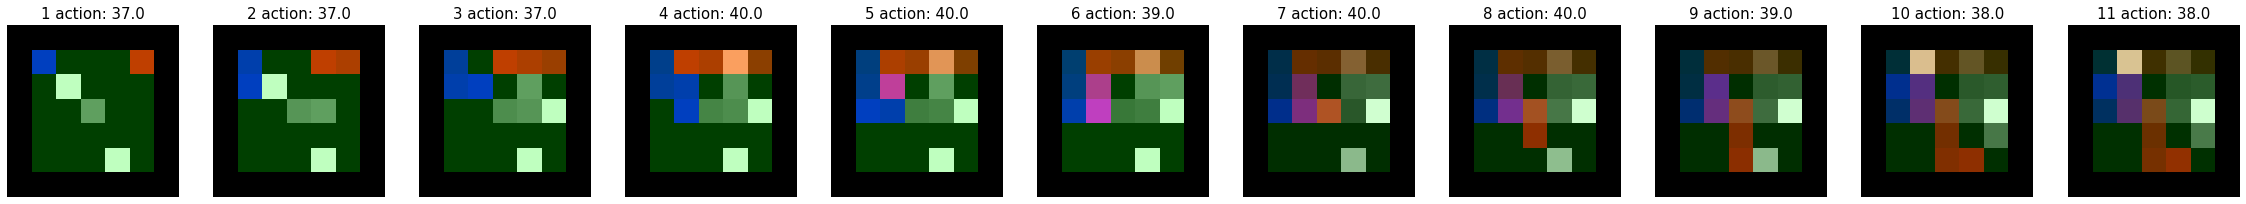

In [24]:
rowToImage('-N2B0PD-NZyuobgfd0kn')

In [ ]:
# index = "-MqplpytsnX0zCv_KW9i"
# col = 3
# plt.imshow(state_df.loc[index, col])
# title = "id: " + index + ", col: " + str(col) + ", action: " + str(action_df.loc[index, col])
# plt.title(title)
# plt.show()